# Initial Models
## Notebook 4
###
####

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# sklearn preprocessors and pipelines:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelBinarizer
from sklearn.compose import  make_column_transformer
from sklearn.pipeline import Pipeline


# sklearn models:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#sklearn metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc

# from custom functions directory imports 
from custom_functions.preprocessor import Preprocessor_function

### Importing and splitting the dataset
Below I import the data and follow the splitting strategy that was mentioned in Notebook 3:

In [53]:
data = pd.read_csv('data_clean/for_models_dataset.csv')

X = data.drop(columns=['Customer_ID', 'Credit_Score'])
y = data['Credit_Score']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     random_state=42,
                     test_size=0.2,
                     stratify=y)

target_names = ['Good', 'Poor', 'Standard'] # needed for classification report

### Baseline Accuracy to be achieved by classifiers:

1st way to calculate it (using value counts):

In [54]:
baseline_accuracy = y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy: {baseline_accuracy*100:.2f}%")

Baseline accuracy: 51.88%


Another way to calculate it (using Dummy Classifier):

In [55]:
# Initialize the dummy classifier
dummy = DummyClassifier(strategy='most_frequent', random_state=42)

# Fit the dummy classifier
dummy.fit(X_train, y_train)

# Use the dummy classifier to make predictions
dummy_preds = dummy.predict(X_test)

# Evaluate the baseline model
baseline_accuracy = accuracy_score(y_test, dummy_preds)

print(f"Baseline accuracy: {baseline_accuracy*100:.2f}%")

Baseline accuracy: 51.88%


#### Creating column transformers with the Preprocessor_function

In [56]:
pr_oh = \
    Preprocessor_function(data = data,
                          target_variable = 'Credit_Score',
                          cat_encoder = 'oh',
                          excluded_features = ['Customer_ID']
                          ).fit(data)


pr_ord = \
    Preprocessor_function(data = data,
                          target_variable = 'Credit_Score',
                          cat_encoder = 'ord',
                          excluded_features = ['Customer_ID']
                          ).fit(data)

pr_oh

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Age', 'Annual_Income', 'Outstanding_Debt',
                                  'Total_EMI_per_month', 'Delay_from_due_date',
                                  'Num_of_Delayed_Payment',
                                  'Credit_Utilization_Ratio']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['Payment_Behaviour', 'Credit_Mix',
                                  'Payment_of_Min_Amount', 'Occupation'])])

### Logistic Regression Models
Below I create pipelines with a final estimator the Logistic Regression Classifier:

In [57]:
model_lr = \
Pipeline([
    ('preprocessor',pr_oh),
    ('estimator', LogisticRegression(multi_class='multinomial',random_state=42))
])

model_lr.fit(X_train, y_train)

score_acc = model_lr.score(X_test, y_test)


score_acc

0.5608

In [58]:
print(f"Baseline accuracy: {score_acc}")
print(classification_report(y_test, model_lr.predict(X_test),
                            target_names=target_names))

Baseline accuracy: 0.5608
              precision    recall  f1-score   support

        Good       0.50      0.47      0.49       483
        Poor       0.55      0.35      0.43       720
    Standard       0.58      0.71      0.64      1297

    accuracy                           0.56      2500
   macro avg       0.54      0.51      0.52      2500
weighted avg       0.56      0.56      0.55      2500


In [70]:
def multiclass_roc_auc_score_and_plot(model, X_test, y_test):
    """
    Calculate multiclass ROC AUC score and plot ROC curves.

    :param model: Fitted classifier model.
    :param X_test: Test data that is used to predict probabilities.
    :param y_test: Test labels.

    :returns: Dictionary of AUC scores for each class and ROC Curves plot
    """
    y_prob = model.predict_proba(X_test)

    # Binarize the labels
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    # Get class names from your fitted model
    class_names = model.classes_

    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Plot of a ROC curve for a specific class
    plt.figure()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic of classification model (multi-class')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

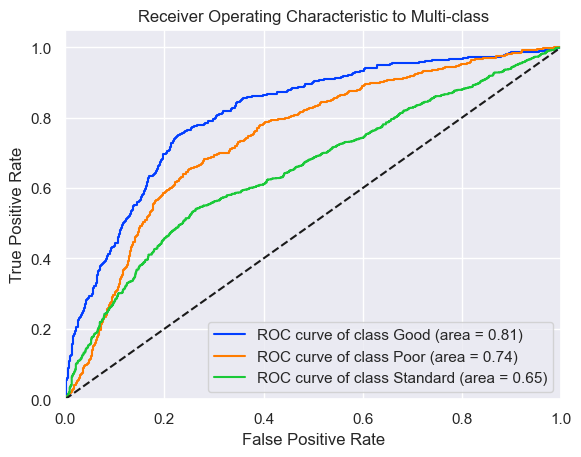

{0: 0.812117703454385, 1: 0.7436719725343319, 2: 0.6522546114795253}

In [72]:
auc_scores = multiclass_roc_auc_score_and_plot(model_lr, X_test, y_test)